In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from sklearn.metrics import jaccard_score, accuracy_score, f1_score
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import glob

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Download Dataset from Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d balraj98/facades-dataset -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/balraj98/facades-dataset
License(s): other


In [ ]:
class FacadeDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.root = root
        self.transform = transform
        self.mode = mode

        if self.mode == 'train':
            self.label_paths = sorted(glob.glob(os.path.join(root, "trainB", "*.jpg")))
            self.image_paths = sorted(glob.glob(os.path.join(root, "trainA", "*.jpg")))
        if self.mode == 'test':
            self.label_paths = sorted(glob.glob(os.path.join(root, "testB", "*.jpg")))
            self.image_paths = sorted(glob.glob(os.path.join(root, "testA", "*.jpg")))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        label = Image.open(self.label_paths[idx]).convert("RGB")
        image = Image.open(self.image_paths[idx]).convert("RGB")

        if self.transform:
            label = self.transform(label)
            image = self.transform(image)

        return label, image

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Datasets
dataset_path = "./"
train_dataset = FacadeDataset(root=dataset_path, mode='train', transform=transform)
# Split the dataset: 80% train, 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = FacadeDataset(root=dataset_path, mode='test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def conv_block(in_channels, out_channels, bn=True):
            layers = [nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)]
            if bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def deconv_block(in_channels, out_channels, dropout=False):
            layers = [nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(out_channels),
                      nn.ReLU(inplace=True)]
            if dropout:
                layers.append(nn.Dropout(0.5))
            return nn.Sequential(*layers)

        self.encoder = nn.ModuleList([
            conv_block(3, 64, bn=False),
            conv_block(64, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512),
            conv_block(512, 512)
        ])

        self.decoder = nn.ModuleList([
            deconv_block(512, 512, dropout=True),
            deconv_block(1024, 512, dropout=True),
            deconv_block(1024, 512, dropout=True),
            deconv_block(1024, 512),
            deconv_block(1024, 256),
            deconv_block(512, 128),
            deconv_block(256, 64)
        ])

        self.final = nn.ConvTranspose2d(128, 3, 4, 2, 1)

    def forward(self, x):
        enc_outs = []
        for layer in self.encoder:
            x = layer(x)
            enc_outs.append(x)

        for idx, layer in enumerate(self.decoder):
            x = layer(x)
            x = torch.cat((x, enc_outs[-(idx+2)]), dim=1)

        x = self.final(x)
        return torch.tanh(x)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),  # 6 channels (Concatenated img_A & img_B)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # nn.Conv2d(256, 512, 4, 1, 1),
            # nn.BatchNorm2d(512),
            # nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    # def forward(self, img_A, img_B):
    #     x = torch.cat((img_A, img_B), dim=1)  # Concatenate along the channel dimension
    #     return self.model(x)

    def forward(self, x):  # Now expects a single input (concatenated image)
        return self.model(x)

In [ ]:
def train(generator, discriminator, train_loader, val_loader, epochs=200, batch_size=8, lr=0.0002, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    generator.to(device)
    discriminator.to(device)

    # Loss Functions
    adversarial_loss = nn.BCEWithLogitsLoss().to(device)  # cGAN Loss
    l1_loss = nn.L1Loss().to(device)  # L1 Loss for pixel-wise similarity

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

    train_losses = []
    val_losses = []
    min_val_loss = float("inf")
    no_improve_epochs = 0  # Early stopping counter

    for epoch in range(epochs):
        generator.train()
        discriminator.train()

        total_g_loss = 0.0
        total_d_loss = 0.0

        for img_A, img_B in train_loader:
            img_A, img_B = img_A.to(device), img_B.to(device)

            # Generate fake images
            fake_B = generator(img_A)

            ## Train Discriminator ##
            optimizer_D.zero_grad()

            # Real loss
            real_input = torch.cat((img_A, img_B), dim=1)  # Condition + Real
            real_preds = discriminator(real_input)
            real_loss = adversarial_loss(real_preds, torch.ones_like(real_preds))  # Target = 1 (real)

            # Fake loss
            fake_input = torch.cat((img_A, fake_B.detach()), dim=1)  # Condition + Fake
            fake_preds = discriminator(fake_input)
            fake_loss = adversarial_loss(fake_preds, torch.zeros_like(fake_preds))  # Target = 0 (fake)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            ## Train Generator ##
            optimizer_G.zero_grad()

            fake_input = torch.cat((img_A, fake_B), dim=1)  # Condition + Fake (for adversarial loss)
            fake_preds = discriminator(fake_input)
            g_adv_loss = adversarial_loss(fake_preds, torch.ones_like(fake_preds))  # Fool discriminator

            g_l1_loss = l1_loss(fake_B, img_B)  # L1 loss for pixel similarity

            g_loss = g_adv_loss + 100 * g_l1_loss  # cGAN loss + L1 loss
            g_loss.backward()
            optimizer_G.step()

            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()

        avg_train_g_loss = total_g_loss / len(train_loader)
        avg_train_d_loss = total_d_loss / len(train_loader)

        # Validation Step
        generator.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for img_A, img_B in val_loader:
                img_A, img_B = img_A.to(device), img_B.to(device)
                fake_B = generator(img_A)
                g_l1_loss = l1_loss(fake_B, img_B)
                total_val_loss += g_l1_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        # Store losses
        train_losses.append(avg_train_g_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - Train G Loss: {avg_train_g_loss:.4f}, Train D Loss: {avg_train_d_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early Stopping
        if avg_val_loss < min_val_loss:
            min_val_loss = avg_val_loss
            no_improve_epochs = 0  # Reset counter
            torch.save(generator.state_dict(), "best_generator.pth")  # Save best model
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print("Early stopping triggered. Training stopped.")
            break

    return generator, discriminator, train_losses, val_losses

In [ ]:
def evaluate(generator, test_loader, threshold=0.5):
    ious, accs, dice_scores = [], [], []
    generator.eval()

    for real_A, real_B in test_loader:
        real_A, real_B = real_A.to(device), real_B.to(device)

        with torch.no_grad():
            fake_B = generator(real_A)

        # Convert predictions to binary labels (0 or 1)
        fake_B = (fake_B > threshold).float()
        real_B = (real_B > threshold).float()  # Ensure ground truth is also binary

        # Flatten for sklearn metrics
        y_true = real_B.cpu().numpy().flatten()
        y_pred = fake_B.cpu().numpy().flatten()

        # Compute metrics
        ious.append(jaccard_score(y_true, y_pred, average="macro"))
        accs.append(accuracy_score(y_true, y_pred))
        dice_scores.append(f1_score(y_true, y_pred, average="macro"))

    print(f"IoU: {np.mean(ious):.4f}, Accuracy: {np.mean(accs):.4f}, Dice Score: {np.mean(dice_scores):.4f}")

In [ ]:
def visualize_results(generator, test_loader, num_samples=4, threshold=0.5):
    generator.eval()

    fig, axs = plt.subplots(num_samples, 3, figsize=(10, 4 * num_samples))

    for i, (real_A, real_B) in enumerate(test_loader):
        if i >= num_samples:
            break  # Show only `num_samples` images

        real_A, real_B = real_A.to(device), real_B.to(device)

        with torch.no_grad():
            fake_B = generator(real_A)

        # Convert prediction to binary mask
        fake_B = (fake_B > threshold).float()

        # Move to CPU and convert to numpy
        real_A = real_A.cpu().numpy().transpose(0, 2, 3, 1) * 0.5 + 0.5  # Rescale from [-1,1] to [0,1]
        real_B = real_B.cpu().numpy().transpose(0, 2, 3, 1)
        fake_B = fake_B.cpu().numpy().transpose(0, 2, 3, 1)

        # Plot results
        axs[i, 0].imshow(real_A[0])  # Input Image
        axs[i, 0].set_title("Input Image")
        axs[i, 0].axis("off")

        axs[i, 1].imshow(real_B[0], cmap="gray")  # Ground Truth Facade
        axs[i, 1].set_title("Ground Truth")
        axs[i, 1].axis("off")

        axs[i, 2].imshow(fake_B[0], cmap="gray")  # Predicted Facade
        axs[i, 2].set_title("Predicted Facade")
        axs[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [ ]:
generator, discriminator, train_loss, val_loss = train(generator, discriminator, train_loader, val_loader, epochs=200, batch_size=8, lr=0.0002, patience=100)

Epoch [1/200] - Train G Loss: 41.5471, Train D Loss: 0.6138, Val Loss: 0.3702
Epoch [2/200] - Train G Loss: 36.8373, Train D Loss: 0.5771, Val Loss: 0.3565
Epoch [3/200] - Train G Loss: 36.0702, Train D Loss: 0.5638, Val Loss: 0.3494
Epoch [4/200] - Train G Loss: 35.6133, Train D Loss: 0.5572, Val Loss: 0.3516
Epoch [5/200] - Train G Loss: 35.2429, Train D Loss: 0.5505, Val Loss: 0.3479
Epoch [6/200] - Train G Loss: 34.9829, Train D Loss: 0.5462, Val Loss: 0.3501
Epoch [7/200] - Train G Loss: 34.7403, Train D Loss: 0.5489, Val Loss: 0.3460
Epoch [8/200] - Train G Loss: 34.3626, Train D Loss: 0.5533, Val Loss: 0.3499
Epoch [9/200] - Train G Loss: 34.0797, Train D Loss: 0.5486, Val Loss: 0.3485
Epoch [10/200] - Train G Loss: 33.6176, Train D Loss: 0.5429, Val Loss: 0.3568
Epoch [11/200] - Train G Loss: 33.7068, Train D Loss: 0.5573, Val Loss: 0.3505
Epoch [12/200] - Train G Loss: 33.1291, Train D Loss: 0.5489, Val Loss: 0.3522
Epoch [13/200] - Train G Loss: 32.7588, Train D Loss: 0.5430,

In [ ]:
torch.save(generator.state_dict(), "best_generator.pth")
torch.save(discriminator.state_dict(), "best_discriminator.pth")

In [ ]:
evaluate(generator, test_loader)

IoU: 0.5206, Accuracy: 0.8860, Dice Score: 0.6012


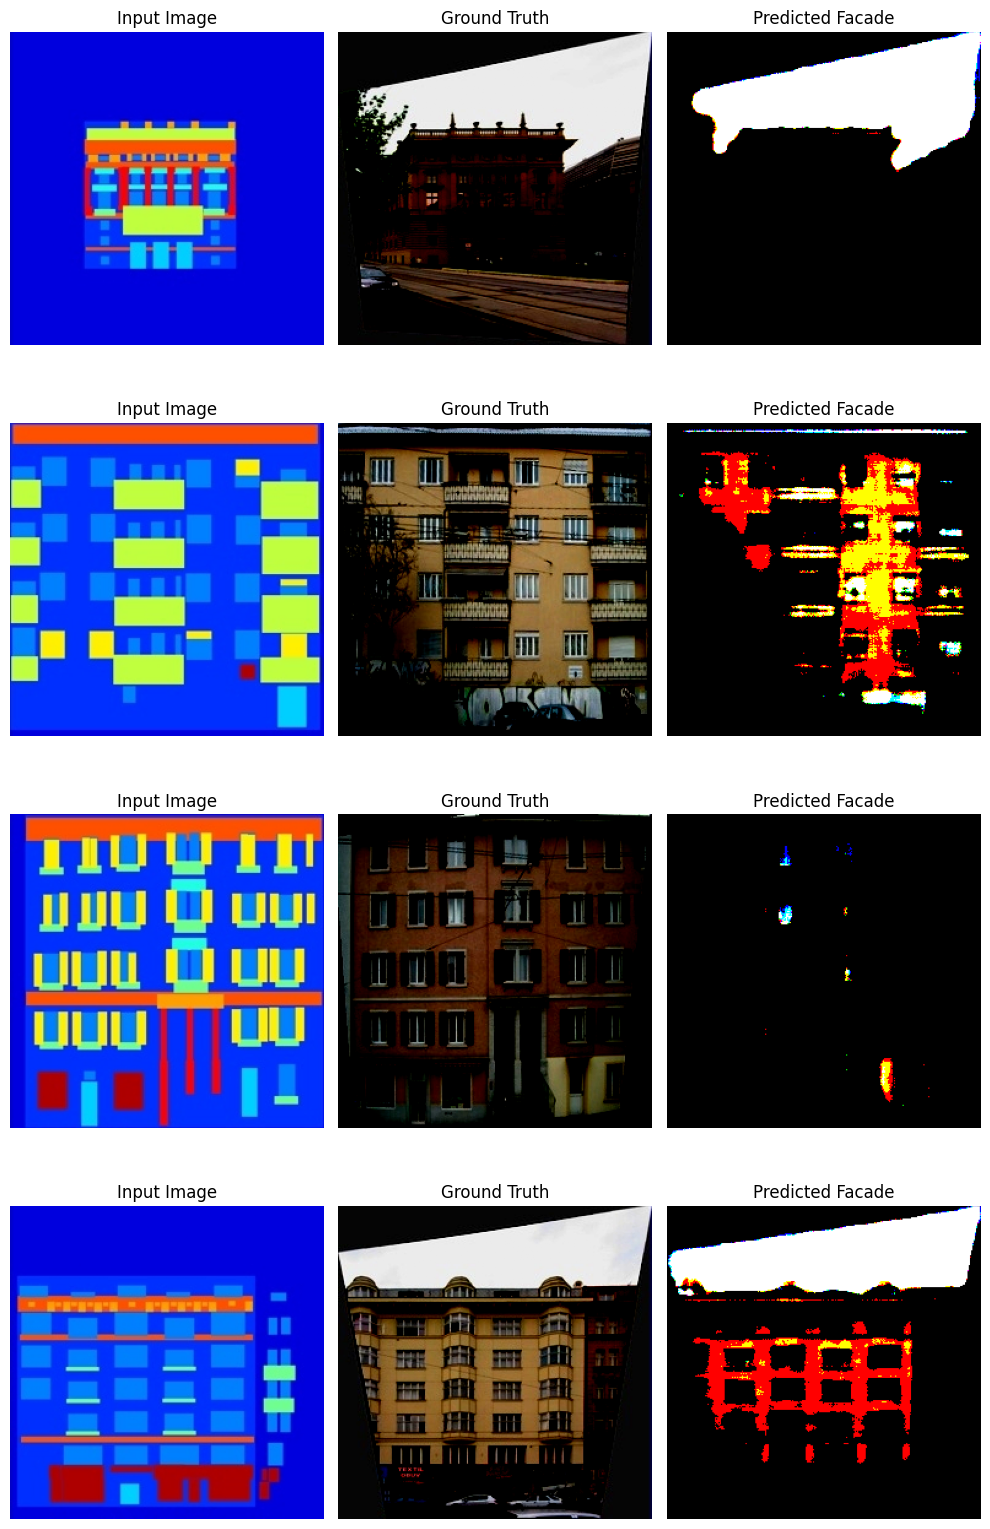

In [ ]:
visualize_results(generator, train_loader, num_samples=4)